In [1]:
import keras
from keras import layers
import numpy as np
import tensorflow as tf

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(32)(x)
encoded = layers.Dense(2)(x)

# at this point the representation is 2-dimensional

x = layers.Dense(32)(encoded)
x = layers.Dense(128)(x)
x = layers.Reshape((4, 4, 8))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [2]:
from keras.datasets import mnist

# Load MNIST dataset from Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images from 28x28 to 784
x_train = (x_train.astype('float32') / 255.)
x_test = (x_test.astype('float32') / 255.)

# Select only specific digits
train_conditions = (y_train == 3) | (y_train == 8) | (y_train == 9)
test_conditions = (y_test == 3) | (y_test == 8) | (y_test == 9)
x_train = x_train[train_conditions]; y_train = y_train[train_conditions]
x_test = x_test[test_conditions]; y_test = y_test[test_conditions]

In [3]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
141/141 [==============================] - 18s 117ms/step - loss: 0.3427 - val_loss: 0.2421
Epoch 2/25
141/141 [==============================] - 12s 86ms/step - loss: 0.2343 - val_loss: 0.2228
Epoch 3/25
141/141 [==============================] - 12s 86ms/step - loss: 0.2188 - val_loss: 0.2115
Epoch 4/25
141/141 [==============================] - 13s 89ms/step - loss: 0.2110 - val_loss: 0.2068
Epoch 5/25
141/141 [==============================] - 12s 86ms/step - loss: 0.2067 - val_loss: 0.2040
Epoch 6/25
141/141 [==============================] - 13s 95ms/step - loss: 0.2038 - val_loss: 0.2012
Epoch 7/25
141/141 [==============================] - 15s 103ms/step - loss: 0.2015 - val_loss: 0.1991
Epoch 8/25
141/141 [==============================] - 13s 90ms/step - loss: 0.1997 - val_loss: 0.1977
Epoch 9/25
141/141 [==============================] - 13s 94ms/step - loss: 0.1981 - val_loss: 0.1963
Epoch 10/25
141/141 [==============================] - 13s 92ms/step - loss: 0.1

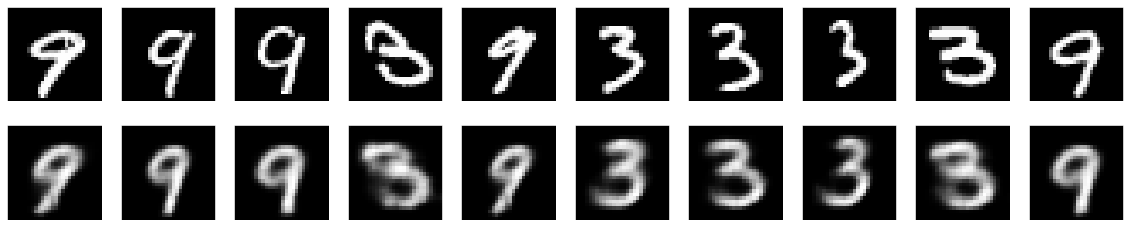

In [4]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

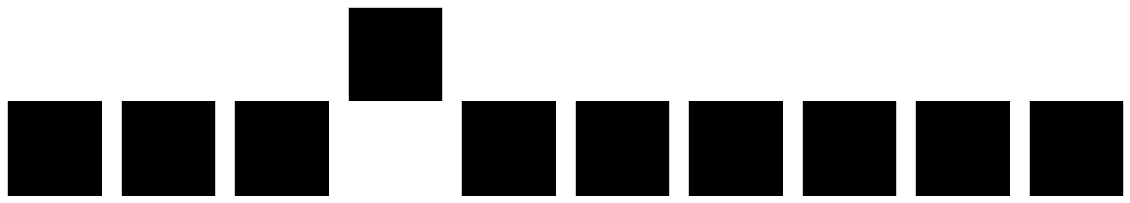

In [5]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((1, 2)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

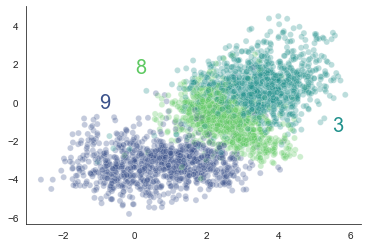

In [6]:
import seaborn as sns

# Plot the latent space colored by label
sns.set_style('white'); sns.set_palette('viridis', 3)
sns.scatterplot(x=encoded_imgs.T[0], y=encoded_imgs.T[1], hue=y_test.astype('str'), alpha=0.3)

# Add labels to the plot
viridis = sns.color_palette('viridis', 3)
plt.text(-1.0, -0.3, '9', size=20, color=viridis[0])
plt.text(5.5, -1.5, '3', size=20, color=viridis[1])
plt.text(0, 1.5, '8', size=20, color=viridis[2])
plt.legend().remove()

sns.despine()
plt.savefig('and_or_gates_autoencoder.png', dpi=200); plt.show()